In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

In [3]:
df.shape

(179856, 9)

In [4]:
# 2- Label trend reversals (example: a simplistic method)
def label_reversal_points(prices, window=8, threshold=0.002):
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect a reversal (trend direction changed)
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy signal at start of uptrend
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell signal at start of downtrend

        # Update previous trend only if there is a new clear trend
        if curr_trend != 0:
            prev_trend = curr_trend

    return labels


df['Label'] = label_reversal_points(df['CLOSE'].values)

In [5]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Drop NaN rows (from weekend gaps)
    df_plot = df.dropna(subset=['CLOSE']).tail(n).copy()

    # Reset index so we can use DATETIME as a column
    df_plot = df_plot.reset_index()
    df_plot.rename(columns={'index': 'DATETIME'}, inplace=True)

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()


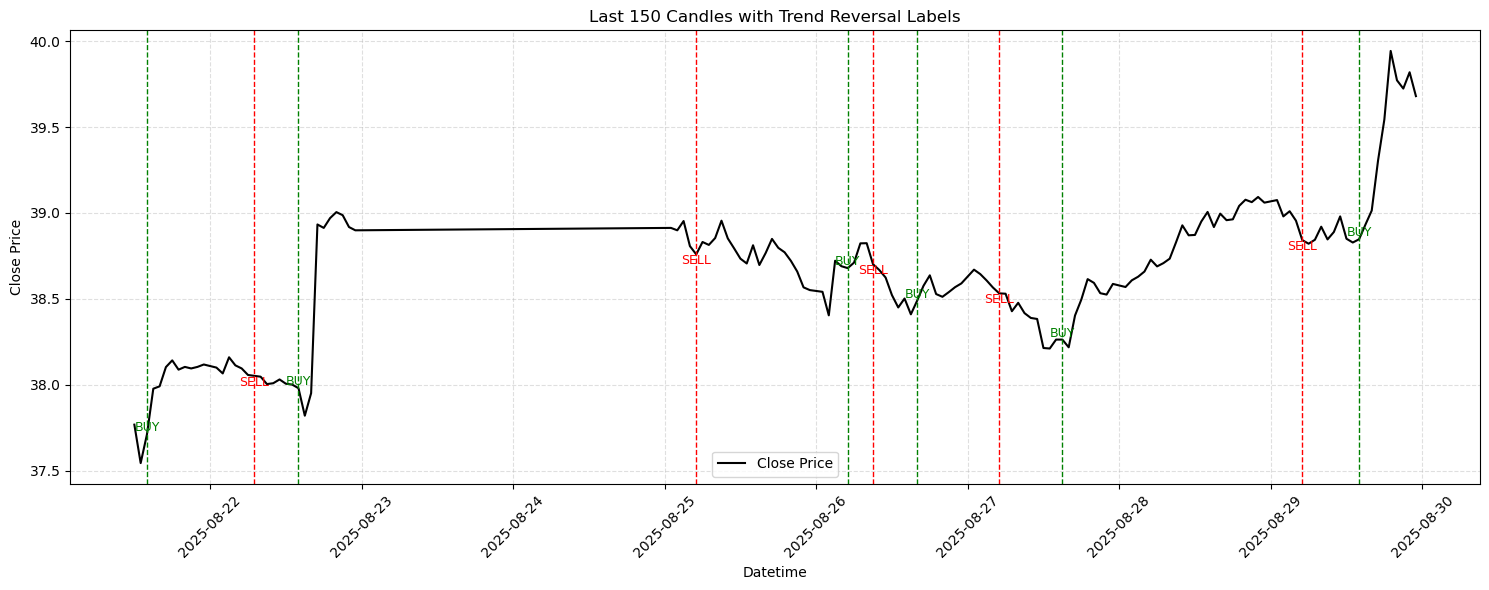

In [6]:
plot_labeled_candles(df)